In [9]:
# Testing pairs trading (KO + PEP)
# Author: Man Hei LI
# Date -- 27 Feb 2024

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Download stock data
# Reference -- https://towardsdatascience.com/historical-stock-price-data-in-python-a0b6dc826836
# !pip install yfinance
import yfinance as yf

[*********************100%%**********************]  2 of 2 completed


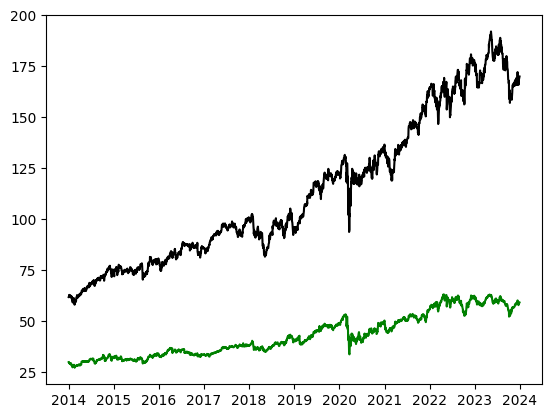

In [4]:
# Plot Pepsi and KO stock price + another chart showing daily returns
# Use a ticker list instead this time

ticker_list = ['KO','PEP']
df = yf.download(ticker_list,'2014-01-01','2023-12-31')
date = df.reset_index()['Date']
#print(df.head())
#print(df['Adj Close']['KO'])
fig,ax=plt.subplots()
ax.plot(date,df['Adj Close']['KO'],'green')
ax.plot(date,df['Adj Close']['PEP'],'black')
plt.show()

#calculate returns
ret = df['Adj Close'].pct_change(periods=1) #default is one
ret = ret.dropna(axis=0)
ret.reset_index(inplace=True)
#print(ret)

#fig,ax=plt.subplots()
#ax.plot(ret["Date"],ret["KO"],'green')
#ax.plot(ret["Date"],ret["PEP"],'black')
#plt.show()

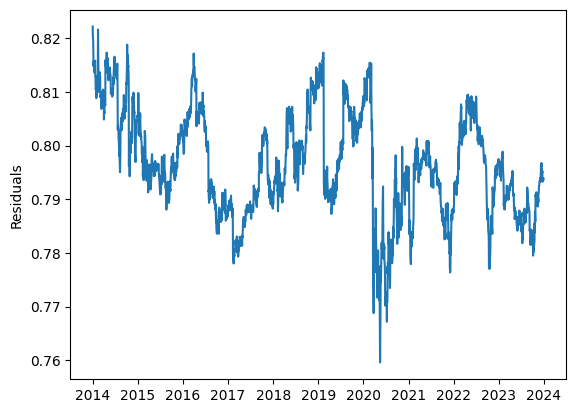

In [5]:
# check residuals then stationarity for pairs trading

y = np.log(np.array(df['Adj Close']['KO']))
x = np.log(np.array(df['Adj Close']['PEP']).reshape(-1,1))
x_org = np.log(np.array(df['Adj Close']['PEP']))

spread = y/x_org

fig, ax = plt.subplots()
ax.plot(date,spread)
plt.ylabel('Residuals')
plt.show()

In [6]:
# Check Residuals with ADF (con't)
#!pip3 install statsmodels

import statsmodels.api as sm

adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
print(f"ADF Test Statistics: {adf[0]}; p-value: {adf[1]}")

ADF Test Statistics: -4.637043947912528; p-value: 0.00011031570395536335


Mean; 0.7963977783683682 and Sigma: 0.009805241019314974


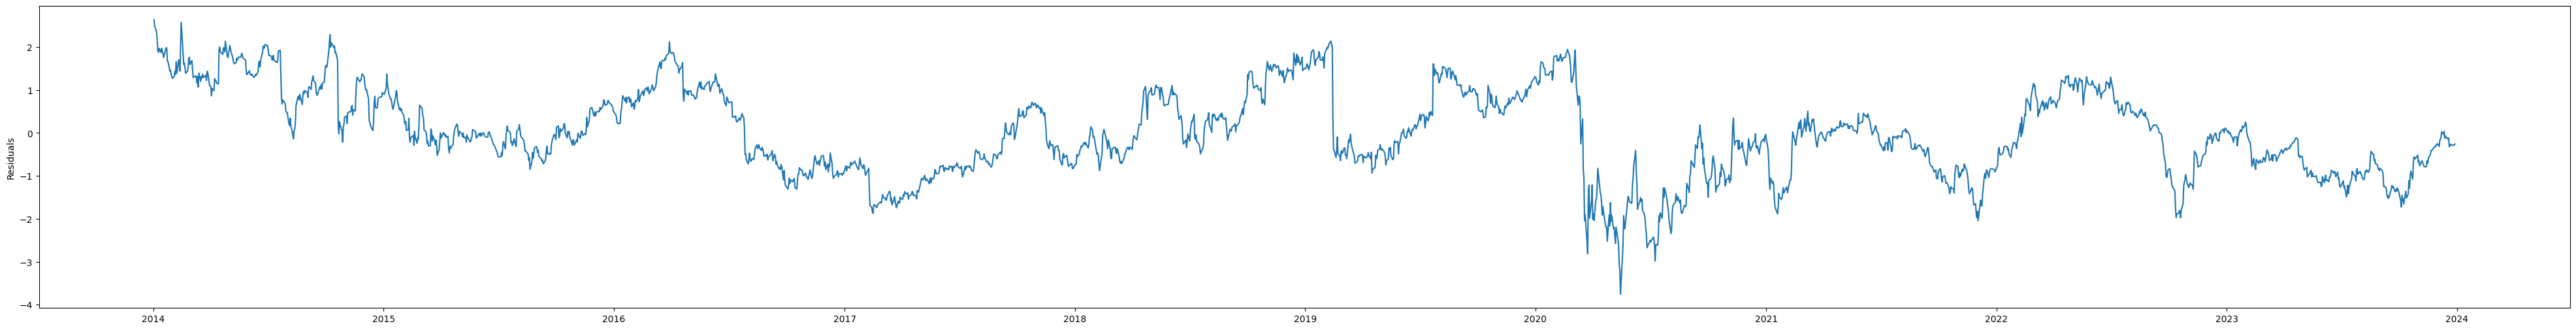

In [7]:
# Analyze normalized z-spread

sigma = spread.std()
mean = spread.mean()
print(f"Mean; {mean} and Sigma: {sigma}")

zscore_spread = (spread-mean)/sigma

fig, ax = plt.subplots(figsize=(50,6))
ax.plot(date,zscore_spread)
plt.ylabel('Residuals')
plt.show()

In [8]:
# Generate trading signal to enter/exit
# if z-score lower than 1.5, long KO short Pepsi
# if z-score higher than 1.5, short KO long Pepsi
# if z-score between [-0.25,0.25] -> close position

backtestpt = pd.concat([date,pd.DataFrame(zscore_spread,columns=['z-score spread'])],axis=1)

# Concat returns and ensure row # the same
backtestpt = backtestpt.merge(ret[["Date","KO","PEP"]],how='inner',on="Date")
backtestpt[['KO_trade','PEP_trade','action','cum_ret']]=0

# apply open position rule
def rowcheck(df):
    if df['z-score spread'] > 1.5:
        df['action'] = 1
    elif df['z-score spread'] < -1.5:
        df['action'] = -1
    else:
        pass
    return df

backtestpt = backtestpt.apply(rowcheck,axis=1)

templist = []
zscorelist = backtestpt['z-score spread'].tolist()
actionlist = backtestpt['action'].tolist()

# apply close position rule
for i in range(len(zscorelist)):
    zscore = zscorelist[i]
    action = actionlist[i]
    if i==0:
        templist.append(action)
    else:
        if status == action:
            templist.append(action)
        elif status == 1 and action == 0:
            if zscore>0.25:
                action = 1
            templist.append(action)    
        elif status == -1 and action == 0:
            if zscore<-0.25:
                action = -1
            templist.append(action)
        else:
            templist.append(action)

    status = action
    zscore, action = 0,0

backtestpt['action'] = templist
backtestpt.head()

,Date,z-score spread,KO,PEP,KO_trade,PEP_trade,action,cum_ret
0,2014-01-03,2.477097,-0.004919,0.001705,0,0,1,0
1,2014-01-06,2.350778,-0.004696,0.000487,0,0,1,0
2,2014-01-07,2.131635,0.002980,0.014584,0,0,1,0
3,2014-01-08,1.913285,-0.011142,-0.002875,0,0,1,0
4,2014-01-09,1.877643,-0.005258,-0.004685,0,0,1,0


In [10]:
# Continue showcasing the results

backtestpt.loc[backtestpt['action']==1,'KO_trade'] = -1
backtestpt.loc[backtestpt['action']==1,'PEP_trade'] = 1
backtestpt.loc[backtestpt['action']==-1,'KO_trade'] = 1
backtestpt.loc[backtestpt['action']==-1,'PEP_trade'] = -1

backtestpt['cum_ret'] = (1+backtestpt['KO']*backtestpt['KO_trade'])*(1+backtestpt['PEP']*backtestpt['PEP_trade'])
backtestpt['cum_ret'] = backtestpt['cum_ret'].cumprod()
backtestpt

,Date,z-score spread,KO,PEP,KO_trade,PEP_trade,action,cum_ret
0,2014-01-03,2.477097,-0.004919,0.001705,-1,1,1,1.006632
1,2014-01-06,2.350778,-0.004696,0.000487,-1,1,1,1.011851
2,2014-01-07,2.131635,0.002980,0.014584,-1,1,1,1.023549
3,2014-01-08,1.913285,-0.011142,-0.002875,-1,1,1,1.031978
4,2014-01-09,1.877643,-0.005258,-0.004685,-1,1,1,1.032543
...,...,...,...,...,...,...,...,...
2510,2023-12-22,-0.263824,0.005691,0.004252,0,0,0,1.265288
2511,2023-12-26,-0.292852,0.004115,0.007037,0,0,0,1.265288
2512,2023-12-27,-0.292363,0.002561,0.003198,0,0,0,1.265288
2513,2023-12-28,-0.277898,0.000681,-0.000059,0,0,0,1.265288


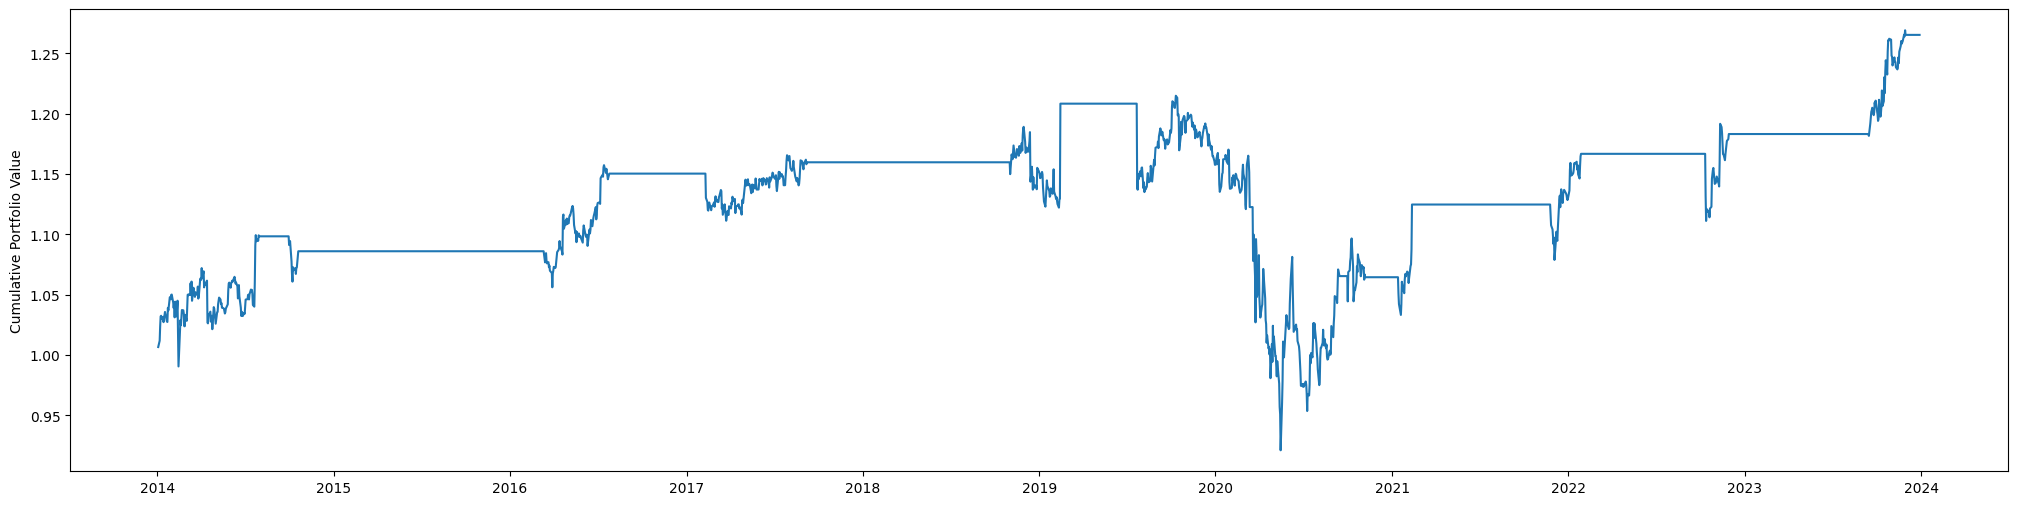

In [11]:
# plot the results

date = backtestpt['Date'].tolist()
cumret = backtestpt['cum_ret'].tolist()

fig, ax = plt.subplots(figsize=(25,6))
ax.plot(date,cumret)
plt.ylabel('Cumulative Portfolio Value')
plt.show()

# caveats -- short sell borrowing rate + spread divergence during recession